# Create Necessary Sequence DataSet for My RNN Model!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
plt.rcParams['figure.figsize']=(20,20)
plt.rcParams['image.cmap']='gray'
% %matplotlib inline

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def imshow(X,Y=None,classes=None):
    '''
        show Batch of image in grids sqrt(h) x sqrt(w)
        X is a numpy array,size (m,h,w,c)
        Y is a numpy array,size (m,#classes)
    '''
    m=X.shape[0]
    gridSize=int(m**0.5)
    for i in range(0,gridSize):
        for j in range(0,gridSize):
            _idx=i*gridSize+j
            im=X[_idx]
            plt.subplot(gridSize,gridSize,_idx+1)
            plt.axis('off')
            plt.imshow(im)
            if Y is not None:
                label=classes[np.argmax(Y[_idx])]
                plt.title(label)

## another problem is using LeNet slide over to read numbers
first lets load mnist dataset

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnistPath='../AI_database/mnist/MNIST_DATA'
def load_dataset(flaten=False,one_hot=True):
    def _make_one_hot(d,C=10):
        return (np.arange(C)==d[:,None]).astype(np.int32)

    mnist=input_data.read_data_sets(mnistPath)
    X_train,Y_train=mnist.train.images,mnist.train.labels
    X_test,Y_test=mnist.test.images,mnist.test.labels

    if flaten==False:
        X_train=X_train.reshape((-1,28,28,1))
        X_test = X_test.reshape((-1, 28, 28,1))
    if one_hot:
        Y_train = _make_one_hot(Y_train)
        Y_test=_make_one_hot(Y_test)


    print('\n-------------------------------------------------------------------------')
    print('load %d train Example,%d Test Example'%(X_train.shape[0],X_test.shape[0]))
    print('Train Images  Shape:'+str(X_train.shape))
    print('Train Labels  Shape:' + str(Y_train.shape))
    print('Test  Images  Shape:'+str(X_test.shape))
    print('Test  Labels  Shape:' + str(Y_test.shape))
    print('-------------------------------------------------------------------------')
    return (X_train,Y_train,X_test,Y_test)

In [6]:
X_train,Y_train,X_test,Y_test=load_dataset(one_hot=True)

Extracting ../AI_database/mnist/MNIST_DATA/train-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting ../AI_database/mnist/MNIST_DATA/t10k-labels-idx1-ubyte.gz

-------------------------------------------------------------------------
load 55000 train Example,10000 Test Example
Train Images  Shape:(55000, 28, 28, 1)
Train Labels  Shape:(55000, 10)
Test  Images  Shape:(10000, 28, 28, 1)
Test  Labels  Shape:(10000, 10)
-------------------------------------------------------------------------


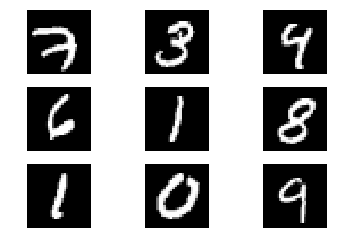

In [7]:
#random chioce 9 digital
seed=0
np.random.seed(seed)
m=X_train.shape[0]
idxes=np.arange(m)
np.random.shuffle(idxes)
top=9
X,Y=X_train[:top],Y_train[:top]
imshow(np.squeeze(X))


In [8]:
'''
    return a picture of digits size: H,W*n,1
'''
def digits(X,Y,Ty=64,maxNum=10):
    '''
        generate a image contain maxNum's characters,some char may
        be blank(labeled as 11) for seq2seq model
        
        X:standard mnist db,shape [?,28,28,1]
        Y:standard mnist db,shape [?,10]
        Ty:sequence length of output
        Tx:sequence length of input,28 x maxNum
        
        return retX:[28,28xmaxNum,1]
               retY:[Ty], 11 classes
    '''
    m,h,w,c=X.shape
    Tx=maxNum*w
    #a help function convert input steps to output steps
    def _convert(s,e):
        ret_s,ret_y=int(s*Ty/Tx),int(e*Ty/Tx)
        return ret_s,ret_y
    n=np.random.randint(3,maxNum+1) # at least 3 digits
    
    #
    #random choose maxNum image from Sample X,then set last maxNum-n to blank 
    idxes=np.arange(m)
    np.random.shuffle(idxes)
    selectIndex=idxes[:maxNum]  #the index of random chioce
    selectX=X[selectIndex]#shape [maxNum,28,28,1]
    selectX[n:]=0
    #using fancy thick, convert to a list with item shape[28,28,1],so concate along axis=1
    retX=np.concatenate(list(selectX),axis=1)  #shape [28,28xmaxNum,1]
    
    #handle ret_Y
    Y=np.argmax(Y,axis=1) #shape [m,]
    selectY=Y[selectIndex] #shape[maxNum,]

    retY=np.zeros(Ty)+10 #initial to all black
    WS=7 #window size
    for i in range(n):
        s,e=w*i+WS,w*i+w-WS
        s,e=_convert(s,e)
        retY[s:e]=selectY[i]
        
    return retX,retY

[10.  1.  1.  1. 10. 10. 10. 10.  7.  7.  7. 10. 10. 10.  6.  6.  6. 10.
 10. 10.  5.  5.  5.  5. 10. 10. 10.  7.  7.  7. 10. 10. 10.  6.  6.  6.
 10. 10. 10. 10.  8.  8.  8. 10. 10. 10.  2.  2.  2. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


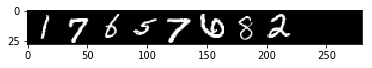

In [9]:
X,Y=digits(X_train,Y_train,Ty=64,maxNum=10)
print(Y)
plt.imshow(np.squeeze(X))

In [10]:
def mnistSeqDB(filename,sX,sY,dbSize=55000,maxNum=10,Ty=64,seed=None):
    '''
        sX,sY come from mnist db (m,28,28,1),(m,10)
    '''
    
    np.random.seed(seed)
    Xs,Ys=[],[]
    for k in range(dbSize):
        X,Y=digits(sX,sY,maxNum=maxNum,Ty=Ty)
        Xs.append(X)
        Ys.append(Y)
        if k%5000==0:print('%d/%d'%(k,dbSize))
    Xs=np.array(Xs)
    Ys=np.array(Ys)
    hf =h5py.File(filename,'w')
    hf.create_dataset('X', data=Xs)
    hf.create_dataset('Y', data=Ys)
    hf.close()

In [12]:
filename='../AI_database/mnistSeq/mnistSeq10k.h5'
mnistSeqDB(filename,X_train,Y_train,dbSize=10000,maxNum=10,Ty=64)

0/10000
5000/10000


In [13]:
#load Data
hf=h5py.File(filename,'r')
X,Y=np.array(hf.get('X')),np.array(hf.get('Y'))
hf.close()

[10.  6.  6.  6. 10. 10. 10. 10.  0.  0.  0. 10. 10. 10.  1.  1.  1. 10.
 10. 10.  2.  2.  2.  2. 10. 10. 10.  5.  5.  5. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


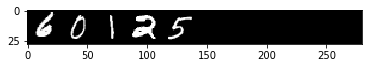

In [14]:
idx=10
x,y=X[idx],Y[idx]
print(y)
plt.imshow(np.squeeze(x))